# Baseline


## Description

In the below implementation, we have mapped the multi-label image classification task to that of a language modelling task. To mimic words and sets of words, the input images are cut up into patches, where each patch represents a word in the set. Each patch of the image is the word and the entire image is synonymous with a sentence. We pass each image patch through the model, retaining the encoding between the patches of the sentence. The final encoding, we take to be the representation of the image and pass it to the fully connected layer whose outputs are interpreted as classification scores.

## Architecture

![RNN Model Architecture](./images/rnn_baseline.jpeg "RNN Baseline Architecture")

## Implementation
Basic outline of the section:
1. Environment setup
2. Model definition
3. Train and Validate functions
4. Set hyperparameters
5. Data Loading
6. Training
7. Testing
8. Evaluation

### 1. Environment Setup

In [1]:
import sys
sys.path.append("..")

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from src.dataset import *
from src.utils import *

from einops import rearrange  

### 2. Model definition

The model architecture is as defined below:

![RNN Model Architecture](./images/rnn_baseline.jpeg "RNN Baseline Architecture")

In [4]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()

        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.layer1 = nn.RNN(self.n_inputs, self.n_neurons)
        self.layer2 = nn.Linear(self.n_neurons, self.n_outputs)

    def init_hidden(self,):
        return torch.zeros(1, self.batch_size, self.n_neurons)

    def forward(self, X, h_init):
        
        # Transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2)

        h_seq , h_final = self.layer1(X , h_init)
        score_seq = self.layer2(h_final)

        return score_seq.view(-1, self.n_outputs), h_final #out.view(-1, self.n_outputs)  # batch_size X n_output

### 3. Train and Validate Functions

In [16]:
def train(model, dataloader, optimizer, criterion, train_data, device):
    
    model.train()
    counter = 0
    
    running_acc = 0.0
    running_loss = 0.0
    running_error = 0.0
    
    h = torch.zeros(1, model.batch_size, model.n_neurons)
    h = h.to(device)
    
    for i, data in enumerate(dataloader):
 
        optimizer.zero_grad()
        counter += 1

        # Get image patches from the input to feed to the RNN.
        inputs, labels = data.values()
        img_patches = rearrange(
            inputs.view(model.batch_size, 3, 144, 256),
            "b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)",
            patch_x=PATCH_SIZE,
            patch_y=PATCH_SIZE,
        )

        img_patches = img_patches.to(device)
        labels = labels.to(device)

        h = h.detach()
        h = h.requires_grad_()

        # forward + backward + optimize
        outputs, h = model(img_patches, h)
        outputs = torch.sigmoid(outputs).to(device)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().item()
        running_error += get_error(outputs.detach(), labels, model.batch_size)
        running_acc += get_accuracy(outputs.detach(), labels, model.batch_size)
        
    total_loss = running_loss / counter
    total_error = running_error / counter

    return total_loss, total_error

In [32]:
def validate(model, dataloader, criterion, val_data, device):
   
    model.eval()
    
    counter = 0
    running_loss = 0.0
    running_error = 0.0
    
    h = torch.zeros(1, model.batch_size, model.n_neurons)
    h = h.to(device)
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            
            counter += 1
            
            # Get image patches from the input to feed to the RNN.
            inputs, labels = data.values()
            img_patches = rearrange(
                inputs.view(model.batch_size, 3, 144, 256),
                "b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)",
                patch_x=PATCH_SIZE,
                patch_y=PATCH_SIZE,
            )
            img_patches = img_patches.to(device)
            labels = labels.to(device)
            
            outputs, h = model(img_patches, h)
            
            # Apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            running_error += get_error(outputs, labels, BATCH_SIZE)
    total_loss = running_loss / counter
    total_error = running_error / counter
    return total_loss, total_error

### 4. Set hyperparameters

In [33]:
N_STEPS = 144
N_INPUTS = 768
N_NEURONS = 150
N_OUTPUTS = 6

N_EPOCHS = 20
BATCH_SIZE = 1

LR = 0.1
PATCH_SIZE = 16

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
model = model.to(device)
display_num_param(model)
print(model)
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

There are 138906 (0.14 million) parameters in this neural network
ImageRNN(
  (layer1): RNN(768, 150)
  (layer2): Linear(in_features=150, out_features=6, bias=True)
)


### 5. Data Loading

In [35]:
train_data = ImageDataset(train=True)
valid_data = ImageDataset(train=False)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

Number of training images: 2065
Number of test images: 365


### 6. Training

In [37]:
train_loss = []
valid_loss = []

for epoch in range(N_EPOCHS):
    
    train_epoch_loss, train_epoch_error = train(model, train_loader, optimizer, criterion, train_data, device)
    valid_epoch_loss, valid_epoch_error = validate(model, valid_loader, criterion, valid_data, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    print(
        "Epoch:  %d | Train Loss: %.4f | Train Error: %.2f Val Loss: %.4f | Val Error: %.2f\n"
        % (epoch, train_epoch_loss, train_epoch_error, valid_epoch_loss, valid_epoch_error)
    )

Epoch:  0 | Train Loss: 0.3770 | Train Error: 15.99 Val Loss: 0.6321 | Val Error: 28.08

Epoch:  1 | Train Loss: 0.3184 | Train Error: 12.62 Val Loss: 0.5896 | Val Error: 26.44

Epoch:  2 | Train Loss: 0.2772 | Train Error: 10.92 Val Loss: 0.6551 | Val Error: 27.40

Epoch:  3 | Train Loss: 0.2461 | Train Error: 9.49 Val Loss: 0.7248 | Val Error: 30.37

Epoch:  4 | Train Loss: 0.2322 | Train Error: 8.87 Val Loss: 0.6678 | Val Error: 27.12

Epoch:  5 | Train Loss: 0.1986 | Train Error: 7.16 Val Loss: 0.6952 | Val Error: 26.30

Epoch:  6 | Train Loss: 0.1857 | Train Error: 6.76 Val Loss: 0.9062 | Val Error: 31.78

Epoch:  7 | Train Loss: 0.1717 | Train Error: 6.19 Val Loss: 0.7693 | Val Error: 27.35

Epoch:  8 | Train Loss: 0.1585 | Train Error: 5.63 Val Loss: 0.7827 | Val Error: 28.77

Epoch:  9 | Train Loss: 0.1451 | Train Error: 4.88 Val Loss: 0.9811 | Val Error: 33.01

Epoch:  10 | Train Loss: 0.1376 | Train Error: 4.62 Val Loss: 0.8897 | Val Error: 28.95

Epoch:  11 | Train Loss: 0.1

### 7. Testing

In [38]:
actors = np.array(CLASSES)
print('actors: ', actors)

test_data = ImageDataset(train=False)
print(test_data[0]['image'].shape, test_data[0]['label'].shape)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']
Number of test images: 365
torch.Size([3, 144, 256]) torch.Size([6])


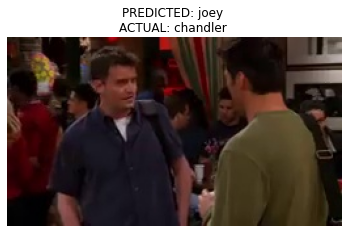

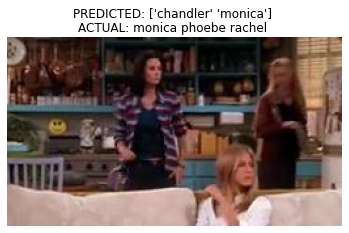

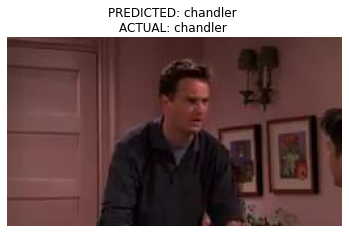

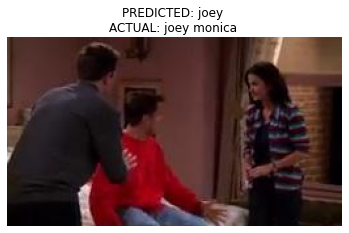

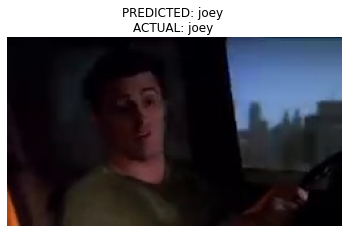

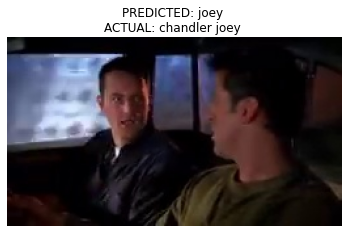

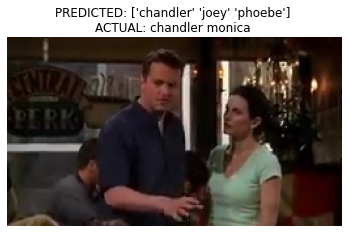

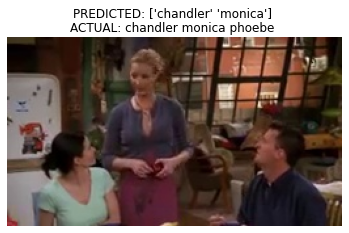

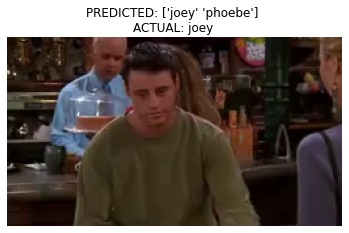

Test Error:  29.166667306652435


In [47]:
model.eval()

running_error = 0.0
running_acc = 0.0
output_list = []
target_list = []

for counter, data in enumerate(test_loader):

    h = torch.zeros(1, BATCH_SIZE, model.n_neurons)
    h = h.to(device)
    inputs, labels = data.values()
    target_indices = [i for i in range(len(labels[0])) if labels[0][i] == 1]
    img_patches = rearrange(
        inputs.view(BATCH_SIZE, 3, 144, 256),
        "b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)",
        patch_x=PATCH_SIZE,
        patch_y=PATCH_SIZE,
    )
    img_patches = img_patches.to(device)
    labels = labels.to(device)
    h = h.detach()
    h = h.requires_grad_()

    outputs, h = model(img_patches, h)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    
    lab = torch.where(outputs>=0.5,1,0)[0]
    pred = torch.where(lab==1)
    
    running_error += get_error(outputs.to(device), labels, 1)
    running_acc += get_accuracy(outputs.to(device), labels, 1)
    
    output_list.append(outputs.numpy())
    target_list.append(labels.cpu().numpy())
    
    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]} "
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]} "
        
    if 10< counter < 20:
        # print(image)
        image = inputs.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()
    
test_error = running_error / counter
print(f"Test Error: ", test_error)

out = np.array(output_list).squeeze(axis=1)
tar = np.array(target_list).squeeze(axis=1)

### 7. Evaluation

In [48]:
f1 = get_f1_score(tar, out)
precision = get_precision_score(tar, out)
recall = get_recall_score(tar, out)
print("F1 score: ", f1)
print('Precision: ', precision)
print('Recall: ', recall)

F1 score:  0.39210697977821257
Precision:  0.4208675799086758
Recall:  0.41292237442922375


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results

For an RNN with three layers of encoding, the following are the results:

1. Training results at the end of 20 epochs:

    * Train Loss: 0.0631
    * Train Error: 1.96
    * Val Loss: 1.1078
    * Val Error: 28.95

2. Test Results:

    * Test Error:  29.167
    * F1 score:  0.3921
    * Precision:  0.4209
    * Recall:  0.4129

## Discussion

The network is performing decently well, however, the class 'Rachel' is predicted more frequently than the rest. The test error witht his network is still quite high.

Possible reasons for this could be:

* **Dataset size** – RNNs require a lot more data to make better predictions.
* **Class distribution** - Overfitting to frequently occuring classes. As we noticed in the EDA, the number of images for some of the characters is not proportionate. This could lead to a bias to the frequently occurring classes.